In [127]:
import ta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import cycler
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Dark mode for charts
colors = cycler('color', ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor='#313233', edgecolor='none', axisbelow=True, grid=True, prop_cycle=colors, labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray'),
plt.rc('ytick', direction='out', color='gray'),
plt.rc('legend', facecolor='#313233', edgecolor='#313233')
plt.rc('text', color='#C9C9C9')
plt.rc('figure', facecolor='#313233')

# Features Engineering

In [3]:
df = yf.download("GOOG")
df = df.drop("Adj Close", axis=1)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512


In [5]:
# SMA, shift is very important to not have errors in algorithm and to not interfere with values that makes the mean
df["SMA 15"] = df[["Close"]].rolling(15).mean().shift(1)
df["SMA 60"] = df[["Close"]].rolling(60).mean().shift(1)

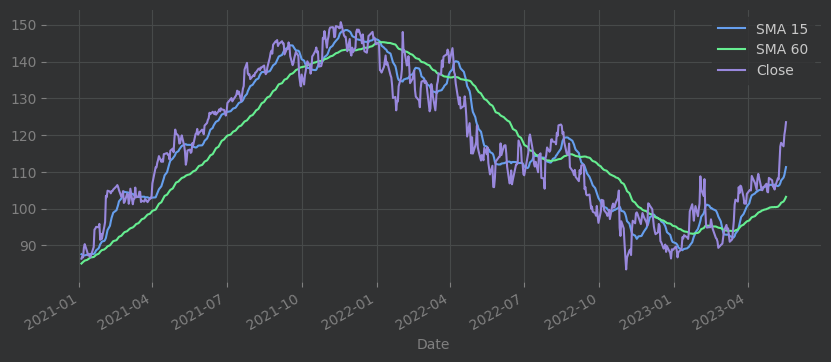

In [6]:
# Plot the chart
df[["SMA 15", "SMA 60", "Close"]].loc["2021":"2023"].plot(figsize=(10, 4))
plt.show()

In [7]:
# Moving Standard Deviation (MSD), percentage change of 1 interval
df["Returns"] = df["Close"].pct_change(1)
df["MSD 15"] = df[["Returns"]].rolling(15).std().shift(1)
df["MSD 60"] = df[["Returns"]].rolling(60).std().shift(1)

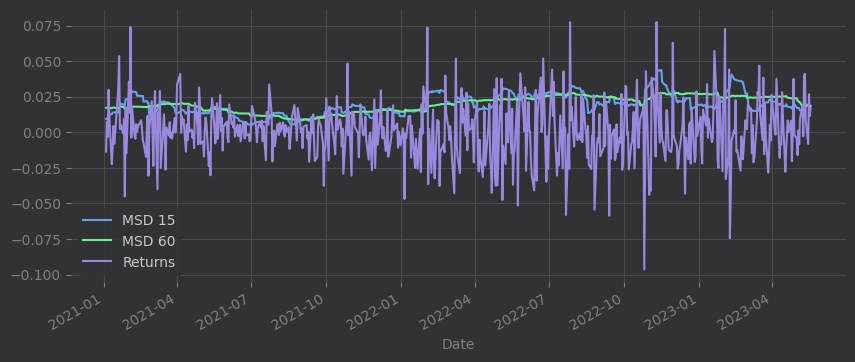

In [8]:
# Plot the chart
df[["MSD 15", "MSD 60", "Returns"]].loc["2021":"2023"].plot(figsize=(10, 4))
plt.show()

In [9]:
# Technical Analysis
RSI = ta.momentum.RSIIndicator(df["Close"], window=14, fillna=False)

In [10]:
df["RSI"] = RSI.rsi()

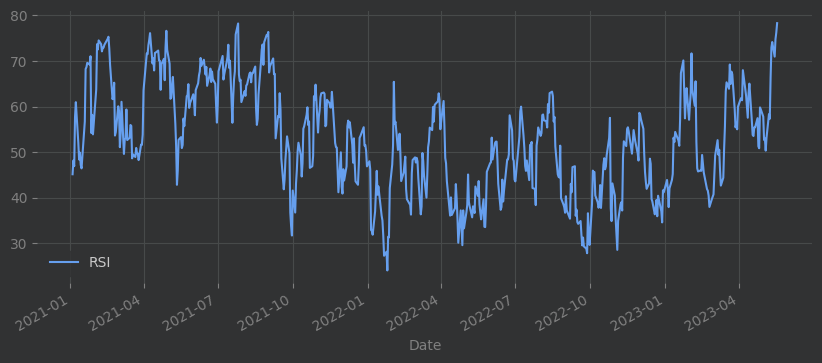

In [11]:
df[["RSI"]].loc["2021":"2023"].plot(figsize=(10, 4))
plt.show()

In [12]:
# Automatization
def feature_engeneering(df):
    df_copy = df.copy()

    df_copy["Returns"] = df_copy["Close"].pct_change(1)

    df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)

    df_copy["MSD 15"] = df_copy[["Returns"]].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy[["Returns"]].rolling(60).std().shift(1)

    RSI = ta.momentum.RSIIndicator(df_copy["Close"], window=14, fillna=False)
    df_copy["RSI"] = RSI.rsi()

    return df_copy

In [13]:
feature_engeneering(df)

,Open,High,Low,Close,Volume,SMA 15,SMA 60,Returns,MSD 15,MSD 60,RSI
Date,,,,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488,NaN,NaN,0.079430,NaN,NaN,NaN
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939,NaN,NaN,0.010064,NaN,NaN,NaN
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159,NaN,NaN,-0.041408,NaN,NaN,NaN
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512,NaN,NaN,0.010775,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12,117.000000,118.260002,116.550003,117.919998,31272500,107.662334,101.603417,0.008725,0.019512,0.018856,74.143663
2023-05-15,116.489998,118.794998,116.480003,116.959999,22107900,108.463000,101.950417,-0.008141,0.019428,0.018703,70.949904
2023-05-16,116.830002,121.199997,116.830002,120.089996,32370100,109.141667,102.303417,0.026761,0.019832,0.018632,74.766403


# Linear Regression Model

In [14]:
df_close = df["Close"]
df_close = pd.DataFrame(df_close)
df_close.head()

,Close
Date,
2004-08-19,2.499133
2004-08-20,2.697639
2004-08-23,2.724787
2004-08-24,2.611960
2004-08-25,2.640104


In [15]:
# Drop NaN values
df = df.dropna()

In [16]:
# Split Data to train and test
split_data = int(0.8*len(df_close))

# Data to predict and split at 80%
X_train = df[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[:split_data]
Y_train = df[["Returns"]].iloc[:split_data]

# Data to test and split at 20%
X_test = df[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[split_data:]
Y_test = df[["Returns"]].iloc[split_data:]

In [98]:
# Training 
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

In [99]:
# Concat data to get the prediction 
X = np.concatenate((X_train, X_test), axis=0)

# Create prediction
df["Prediction"] = lr_model.predict(X)

c:\Users\UserHome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


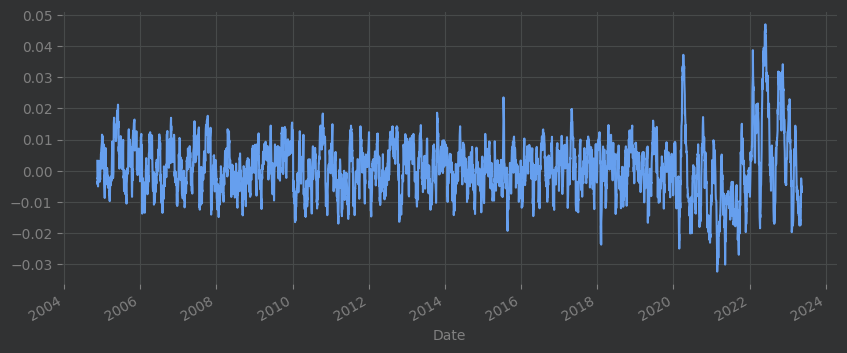

In [100]:
df["Prediction"].plot(figsize=(10, 4))
plt.show()

In [20]:
# Trading strategy where np.sign 1 if the element is positive, 0 if the element is zero, and -1 if the element is negative
df["Position"] = np.sign(df["Prediction"])

# Compute the return
df["Strategy"] = df["Returns"] * df["Position"].shift(1)

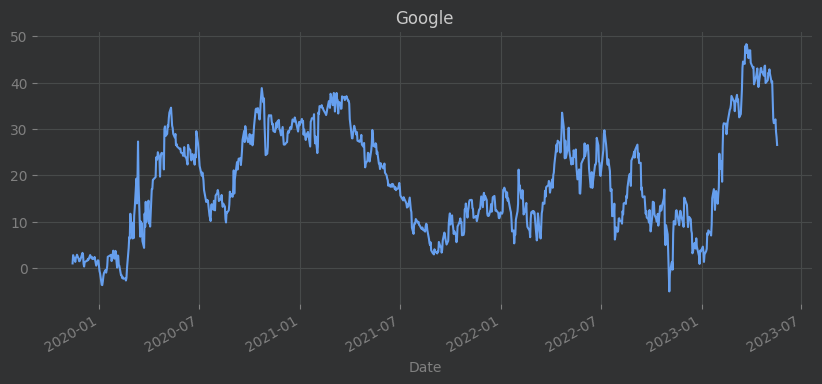

In [21]:
# Cumulative return in order to see if the strategy is profitable or not
(df["Strategy"].iloc[split_data:].cumsum()*100).plot(figsize=(10, 4))
plt.title("Google")
plt.show()

In [22]:
# Process automatization
def linear_regression_trading(symbol):
    def feature_engeneering(df):
        df_copy = df.dropna().copy()

        df_copy["Returns"] = df_copy["Close"].pct_change(1)

        df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
        df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)

        df_copy["MSD 15"] = df_copy[["Returns"]].rolling(15).std().shift(1)
        df_copy["MSD 60"] = df_copy[["Returns"]].rolling(60).std().shift(1)

        RSI = ta.momentum.RSIIndicator(df_copy["Close"], window=14, fillna=False)
        df_copy["RSI"] = RSI.rsi()

        return df_copy.dropna()
    
    df = yf.download(symbol)

    df = df[["Adj Close"]]

    df.columns = ["Close"]

    dfc = feature_engeneering(df)

    split_data = int(0.8*len(dfc))

    X_train = dfc[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[:split_data]
    Y_train = dfc[["Returns"]].iloc[:split_data]

    X_test = dfc[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[split_data:]
    Y_test = dfc[["Returns"]].iloc[split_data:]

    lr_model = LinearRegression()
    lr_model.fit(X_train, Y_train)

    X = np.concatenate((X_train, X_test), axis=0)

    dfc["Prediction"] = lr_model.predict(X)

    dfc["Position"] = np.sign(dfc["Prediction"])

    dfc["Strategy"] = dfc["Returns"] * dfc["Position"].shift(1)

    (dfc["Strategy"].iloc[split_data:].cumsum()*100).plot(figsize=(10, 4))
    plt.title(symbol)
    plt.show()    
        

[*********************100%***********************]  1 of 1 completed


c:\Users\UserHome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


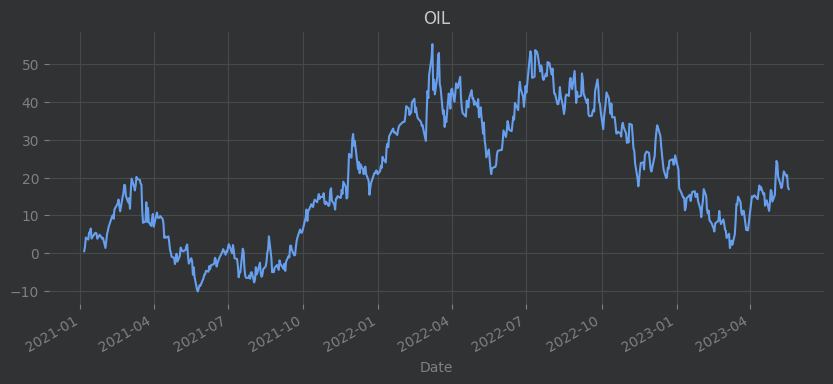

In [23]:
linear_regression_trading("OIL")

# Vectorized Backtesting

### Sortino Ratio

Formula: (R - T) / D
* R is the expected return or average return of the investment    
* T is the target or minimum acceptable return (usually 0 or the risk-free rate)
* D is the downside deviation or downside volatility, which is the standard deviation of negative returns

1. Srtino Ratio < 0 => Investment not profitable, gains are negative
2. Srtino Ratio < 1 => Investment profitable, risk is higher than the return of investment
3. Srtino Ratio > 1 => Investment very profitable, risk is lower than the return of investment


In [24]:
# Prepare the data, add percentage change compared to the last value and drop the NAN values
df_nke = yf.download("NKE", start="2002-01-01", end="2023-01-01", interval="1d")
nke_series = df_nke["Adj Close"].pct_change(1).dropna()
nke_series.name = "Return"

# Sortino indicator, compute the volatility of negative values from series
mean = np.mean(nke_series) # it is multiplied by 252
volatility = np.std(nke_series[nke_series < 0]) # volatility is the sqrt of 252
sortino = np.sqrt(252) * mean / volatility # the square root of 252 is used to annualize the ratio assuming there are 252 trading days in a year

sortino.round(3)

[*********************100%***********************]  1 of 1 completed


0.938

# Beta Metric (CAPM)

Formula: Covariance(R_i, R_m) / Variance(R_m)

* Covariance(R_i, R_m) is the covariance between the returns of the investment (R_i) and the market returns (R_m)
* Variance(R_m) is the variance of the market returns

1. abs(Beta) < 1 => good, portfolio has less variation than the index
2. abs(Beta) > 1 => mot good, portfolio has higher variation than the index

In [25]:
# Get SP500 data
df_sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
df_sp500.name = "SP500"

# Concatenate to make the covariances
val = pd.concat((nke_series, df_sp500), axis=1).dropna()

# Compute beta, rowvar=False means that covariance matrix will have dimensions corresponding to the number of observations
cov_matrix = np.cov(val.values, rowvar=False)

# Compute covariance
cov = cov_matrix[0][1]
var = cov_matrix[1][1]

# Compute beta
beta = cov / var

# In average this asset varies 0.89% when the market varies 1%
beta.round(3)

[*********************100%***********************]  1 of 1 completed


0.93

# Alpha Metric (CAPM)

Formula: Portfolio Return - (Risk-Free Rate + Beta * (Benchmark Return - Risk-Free Rate))

* Portfolio Return is the return of the investment or portfolio
* Risk-Free Rate is the rate of return on a risk-free investment, such as a government bond
* Beta is the measure of the investment's sensitivity to market movements, representing the relationship between the investment's returns and the returns of the benchmark
* Benchmark Return is the return of the benchmark index or asset

1. Alpha > 0 => portfolio outperforms the market in terms of risk / reward
2. Alpha < 0 => portfolio underperforms the market in terms of risk / reward

In [26]:
# Alpha calculation
alpha = 252 * mean * (1 - beta)

# NKE is 0.22% better than SP500
alpha.round(3)

0.013

# Drawdown (Max Loss)

In [27]:
def drawdown_function(serie):
    # Cumulative return
    cum = serie.dropna().cumsum() + 1

    # Max of the cumsum (accumulate max)
    run_max = np.maximum.accumulate(cum)

    # Compute the drawdown
    drawdown = cum / run_max - 1

    return drawdown

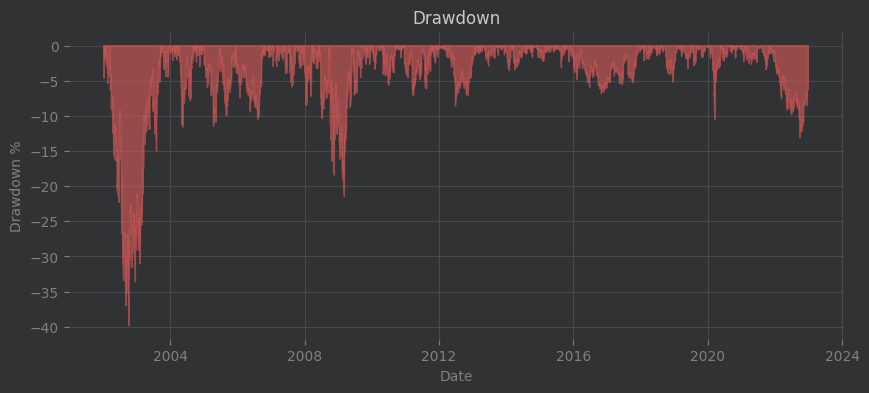

In [29]:
# Assign data
drawdown = drawdown_function(nke_series)

plt.figure(figsize=(10, 4))
plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, color="#CE5757", alpha=0.65)
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown %")
plt.show() 

In [30]:
# Compute max drawdown
max_drawdown = np.min(drawdown)*100

max_drawdown.round(3)

-39.867

# Backtesting Automation

In [31]:
def backtest(serie):
    # Get SP500 data
    df_sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
    df_sp500.name = "SP500"

    # Concatenate to make the covariances
    val = pd.concat((serie, df_sp500), axis=1).dropna()

    # Assign data
    drawdown = drawdown_function(serie)*100

    # Compute max drawdown
    max_drawdown = -np.min(drawdown)

    # Subplots
    fig, (cum, dra) = plt.subplots(1,2, figsize=(14, 4))

    # Subtitle
    fig.suptitle("Backtesting", size=10)

    # Cumulative sum chart
    cum.plot(val["Return"].cumsum()*100, color="#B85A0F")
    cum.plot(val["SP500"].cumsum()*100, color="#1F77B4")

    # Legend
    cum.legend(["Portfolio", "SP500"])

    # Individual title
    cum.set_title("Cumulative Return", size=10) 

    cum.set_ylabel("Cumulative Return %", size=10)

    # Drawdown
    dra.fill_between(drawdown.index, 0, drawdown, color="#C73954", alpha=0.65)  

    # Individual title
    dra.set_title("Drawdown", size=10)

    dra.set_ylabel("Drawdown Return %", size=10)

    plt.show()

    # Sortino
    sortino = np.sqrt(252) * serie.mean() / serie.loc[serie < 0].std()

    # Beta
    beta = np.cov(val[["Return", "SP500"]].values, rowvar=False)[0][1] / np.var(val["SP500"].values)

    # Alpha
    alpha = 252 * serie.mean() - 252 * beta * serie.mean()

    # Print statistics
    print(f"Sortino: {np.round(sortino, 3)}")
    print(f"Beta: {np.round(alpha, 3)}")
    print(f"Alpha: {np.round(beta, 3)}")
    print(f"Max Drawdown: {np.round(max_drawdown, 3)}")

[*********************100%***********************]  1 of 1 completed


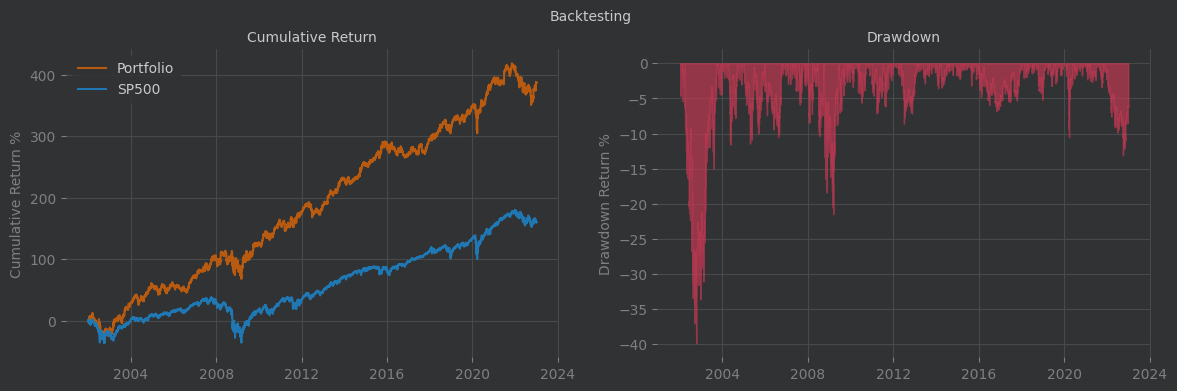

Sortino: 0.938
Beta: 0.013
Alpha: 0.93
Max Drawdown: 39.867


In [32]:
backtest(nke_series)

In [33]:
# Process automatization
def linear_regression_backtest(symbol):
    def feature_engeneering(df):
        df_copy = df.dropna().copy()

        df_copy["Returns"] = df_copy["Close"].pct_change(1)

        df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
        df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)

        df_copy["MSD 15"] = df_copy[["Returns"]].rolling(15).std().shift(1)
        df_copy["MSD 60"] = df_copy[["Returns"]].rolling(60).std().shift(1)

        RSI = ta.momentum.RSIIndicator(df_copy["Close"], window=14, fillna=False)
        df_copy["RSI"] = RSI.rsi()

        return df_copy.dropna()
    
    df = yf.download(symbol)

    df = df[["Adj Close"]]

    df.columns = ["Close"]

    dfc = feature_engeneering(df)

    split_data = int(0.8*len(dfc))

    X_train = dfc[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[:split_data]
    Y_train = dfc[["Returns"]].iloc[:split_data]

    X_test = dfc[["SMA 15", "SMA 60", "MSD 15", "MSD 60", "RSI"]].iloc[split_data:]
    Y_test = dfc[["Returns"]].iloc[split_data:]

    lr_model = LinearRegression()
    lr_model.fit(X_train, Y_train)

    X = np.concatenate((X_train, X_test), axis=0)

    dfc["Prediction"] = lr_model.predict(X)

    dfc["Position"] = np.sign(dfc["Prediction"])

    dfc["Strategy"] = dfc["Returns"] * dfc["Position"].shift(1)

    dfc["Return"] = dfc["Strategy"]  

    backtest(dfc["Return"].iloc[split_data:])

[*********************100%***********************]  1 of 1 completed


c:\Users\UserHome\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[*********************100%***********************]  1 of 1 completed


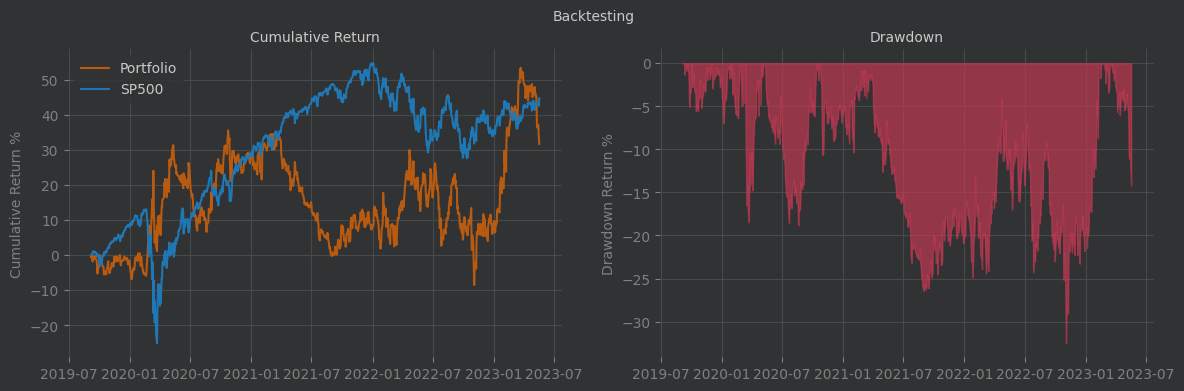

Sortino: 0.384
Beta: 0.069
Alpha: 0.191
Max Drawdown: 32.518


In [34]:
linear_regression_backtest("GOOG")

# All indicators analysis

In [83]:
# Import data
data_frame = yf.download("GOOG")[["Open", "High", "Low", "Adj Close", "Volume"]]
data_frame.columns = ["opne", "high", "low", "close", "volume"]
data_frame.head()

[*********************100%***********************]  1 of 1 completed


,opne,high,low,close,volume
Date,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512


In [84]:
def new_feature_engeneering(df):
    df_copy = df.dropna().copy()

    df_copy["returns"] = df_copy["Close"].pct_change(1)

    # All indicators with ta library
    df_indicators = ta.add_all_ta_features(df, open="open", high="High", low="Low", close="Close", volume="Volume", fillna=True).shift(1)

    dfc = pd.concat((df_indicators, df_copy), axis=1)

    return dfc.dropna()

In [85]:
dfc_new = new_feature_engeneering(df_nke)
dfc_new.head()

c:\Users\UserHome\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\UserHome\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,returns
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,7.04000,7.14750,7.00375,7.11500,5.626148,9688000.0,5.307309e+06,9688000.0,0.547823,0.000000,...,-0.011779,-0.047115,0.839865,0.167973,0.671892,7.096711,-0.737875,-0.740610,-0.737875,-0.007379
2002-01-04,7.14375,7.14375,7.03250,7.06250,5.584633,10716000.0,3.707443e+05,-1028000.0,0.018170,-562587.547302,...,-0.016273,-0.017975,7.575959,1.649570,5.926389,7.106574,0.884956,0.881063,0.140551,0.008850
2002-01-07,7.06250,7.31125,7.06250,7.12500,5.634054,18803200.0,-8.983619e+06,17775200.0,-0.229132,-314332.183402,...,-0.010602,0.022682,6.401720,2.600000,3.801720,7.124889,0.333331,0.332777,0.474351,0.003333
2002-01-08,7.18750,7.24250,7.13125,7.14875,5.652836,10421600.0,-1.612653e+07,28196800.0,-0.324943,-234068.841343,...,0.005641,0.064972,6.945316,3.469063,3.476253,7.144219,0.279769,0.279378,0.755447,0.002798
2002-01-09,7.06875,7.21250,7.06250,7.16875,5.668650,12569600.0,-1.088924e+07,40766400.0,-0.175073,-164717.326829,...,0.004956,-0.002740,3.937927,3.562836,0.375091,7.110664,-1.412376,-1.422445,-0.667599,-0.014124


In [86]:
new_split_data = int(0.8*len(dfc_new))

# Range of columns to train and test
X_train_new = dfc_new.iloc[:new_split_data,6:dfc_new.shape[1]-1]
Y_train_new = dfc_new[["returns"]].iloc[:new_split_data]

X_test_new = dfc_new.iloc[new_split_data:,6:dfc_new.shape[1]-1]
Y_test_new = dfc_new[["returns"]].iloc[new_split_data:]

# Standardisation

In [87]:
# Standardisation, z-score normalization to have a mean of 0 and a standard deviation of 1
sc_model = StandardScaler()

# Mean, standard deviation for each variable
X_train_sc = sc_model.fit_transform(X_train_new)

# Not putting any interference in the data
X_test_sc = sc_model.transform(X_test_new)

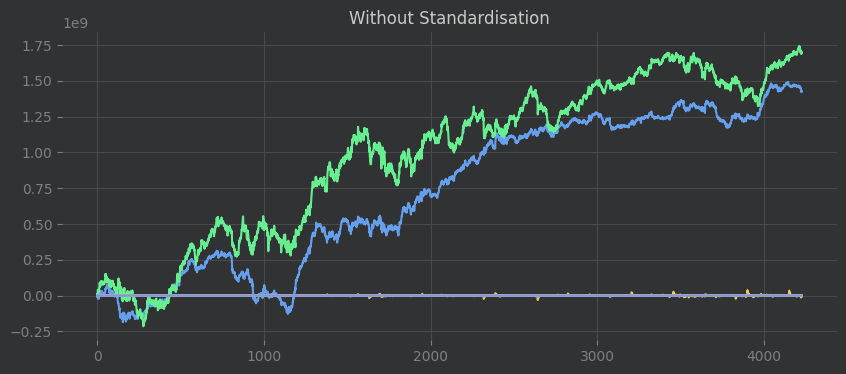

In [88]:
plt.figure(figsize=(10, 4))
plt.plot(X_train_new.values[:,0:15])
plt.title("Without Standardisation")
plt.show()

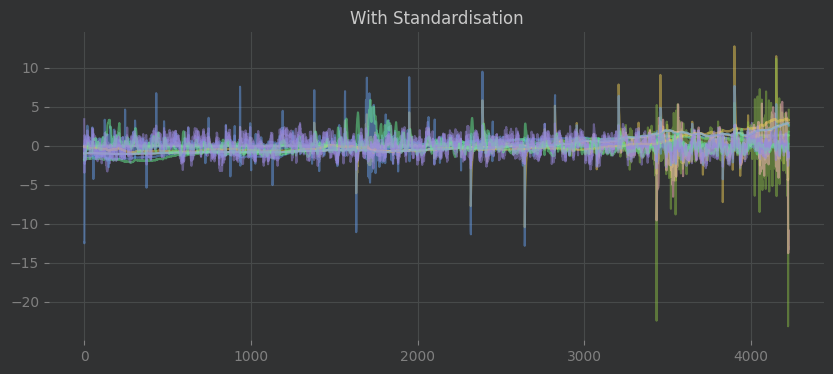

In [89]:
plt.figure(figsize=(10, 4))
plt.plot(X_train_sc[:,0:15], alpha=0.5)
plt.title("With Standardisation")
plt.show()

# Principal Component Analysis

In [90]:
pca_model = PCA(n_components=6)

# Fit and transform on standardized data
X_train_pca = pca_model.fit_transform(X_train_sc)
X_test_pca = pca_model.transform(X_test_sc)

print(f"Without PCA: {np.shape(X_train_new)} \nWith PCA: {np.shape(X_train_pca)}")

Without PCA: (4228, 178) 
With PCA: (4228, 6)
